# Imports

In [1]:
import pandas as pd
import os

from dotenv import load_dotenv

# pandasai imports
from pandasai.llm.openai import OpenAI
from pandasai import SmartDataframe
from pandasai import clear_cache
from pandasai import Agent

# Initialization

In [2]:
READ_FROM_PICKLE = True

In [3]:
# finds .env file and loads the vars
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY", "Key not found")
openai_org = os.getenv("OPENAI_ORG", "Organization not found")

In [4]:
if READ_FROM_PICKLE:
    malicious_df = pd.read_pickle("data/malicious_features_numeric.pkl")
    benign_df = pd.read_pickle("data/benign_features_numeric.pkl")

In [5]:
# Instantiate a LLM
llm = OpenAI(api_token=openai_api_key)

In [6]:
malicious_smart = SmartDataframe(
    df=pd.DataFrame(malicious_df),
    config={"llm": llm, "verbose": True},
    name="Mirai botnet network packet capture.",
    description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.",
)

In [7]:
benign_smart = SmartDataframe(
    df=pd.DataFrame(benign_df),
    config={"llm": llm, "verbose": True},
    name="Packet capture of normal operation network travvid.",
    description="A dataframe that is derived from a packet capture of the regular operation of a network.",
)

In [8]:
malicious_smart.columns

Index(['Timestamp', 'Source Port', 'Destination Port', 'Payload',
       'Packet Length', 'Protocol', 'src_ip_total_bytes', 'dst_ip_total_bytes',
       'Numeric Source IP', 'Numeric Destination IP', 'dst_port_freq_encoded',
       'Interarrival'],
      dtype='object')

# EDA

## Statistical

### Exploration via prompting

In [9]:
top_5_source_IPs = malicious_smart.chat("Which are the 5 most popular source IP addresses?")

top_5_source_IPs

2024-05-15 18:54:00 [INFO] Question: Which are the 5 most popular source IP addresses?
2024-05-15 18:54:00 [INFO] Running PandasAI with openai LLM...
2024-05-15 18:54:00 [INFO] Prompt ID: 47857f03-5290-457e-bc07-06bd2744f5a8
2024-05-15 18:54:00 [INFO] Executing Step 0: CacheLookup
2024-05-15 18:54:00 [INFO] Executing Step 1: PromptGeneration
2024-05-15 18:54:01 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x12
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
6897040485,20532.0,8280.0,Padding,26,6.0,52,26,7981437032,874070778,0.04079434096956324,5.0067901611328125e-06
3768484889,21074.0,80.0,Padding,26,6.0,26,26,9291380408,873999171,0.11450451035109352,
8500684032,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsmartcam.co

,Numeric Source IP,Count
0,3232236140,51747
1,3232236145,34415
2,3232236142,16520
3,3232236147,13486
4,3232236144,9158


In [10]:
print(malicious_smart.last_code_generated)

source_ip_counts = dfs[0]['Numeric Source IP'].value_counts().head(5).reset_index()
source_ip_counts.columns = ['Numeric Source IP', 'Count']
result = {'type': 'dataframe', 'value': source_ip_counts}


In [11]:
top_5_dst_ports = malicious_smart.chat("Find the most used destination ports.")
top_5_dst_ports

2024-05-15 18:54:04 [INFO] Question: Find the most used destination ports.
2024-05-15 18:54:04 [INFO] Running PandasAI with openai LLM...
2024-05-15 18:54:04 [INFO] Prompt ID: 20b88b48-b804-4900-bba2-80747577d911
2024-05-15 18:54:04 [INFO] Executing Step 0: CacheLookup
2024-05-15 18:54:04 [INFO] Executing Step 1: PromptGeneration
2024-05-15 18:54:04 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x12
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
6897040485,20532.0,8280.0,Padding,26,6.0,52,26,7981437032,874070778,0.04079434096956324,5.0067901611328125e-06
3768484889,21074.0,80.0,Padding,26,6.0,26,26,9291380408,873999171,0.11450451035109352,
8500684032,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsmartcam.com.Speedport_

10240.0

In [12]:
print(malicious_smart.last_code_generated)

most_used_ports = dfs[0]['Destination Port'].value_counts().idxmax()
result = {'type': 'number', 'value': most_used_ports}


### Prompt engineering

In [29]:
rare_ports = malicious_smart.chat(
    "Which are the most commonly used known destination ports?"
)
rare_ports

2024-05-15 18:56:12 [INFO] Question: Which are the most commonly used known destination ports?
2024-05-15 18:56:12 [INFO] Running PandasAI with openai LLM...
2024-05-15 18:56:12 [INFO] Prompt ID: 7c395e27-8794-4f9a-8557-3e3f76c8b0df
2024-05-15 18:56:12 [INFO] Executing Step 0: CacheLookup
2024-05-15 18:56:12 [INFO] Executing Step 1: PromptGeneration
2024-05-15 18:56:12 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x12
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
6897040485,20532.0,8280.0,Padding,26,6.0,52,26,7981437032,874070778,0.04079434096956324,5.0067901611328125e-06
3768484889,21074.0,80.0,Padding,26,6.0,26,26,9291380408,873999171,0.11450451035109352,
8500684032,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsma

,Destination Port,Count
0,10240.0,62584
1,53.0,33348
2,80.0,17644
3,23.0,9466
4,21897.0,7158


In [28]:
rare_ports = malicious_smart.chat(
    "Which are the most used destination ports less than or equal to 1024?"
)
rare_ports

2024-05-15 18:55:43 [INFO] Question: Which are the most used destination ports less than or equal to 1024?
2024-05-15 18:55:43 [INFO] Running PandasAI with openai LLM...
2024-05-15 18:55:43 [INFO] Prompt ID: 9118700e-63ed-42ef-bc88-4c45350733fb
2024-05-15 18:55:43 [INFO] Executing Step 0: CacheLookup
2024-05-15 18:55:43 [INFO] Executing Step 1: PromptGeneration
2024-05-15 18:55:43 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x12
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
6897040485,20532.0,8280.0,Padding,26,6.0,52,26,7981437032,874070778,0.04079434096956324,5.0067901611328125e-06
3768484889,21074.0,80.0,Padding,26,6.0,26,26,9291380408,873999171,0.11450451035109352,
8500684032,2440.0,53.0,"DNS Qry ""b'xmp

,Destination Port,Count
0,53.0,33348
1,80.0,17644
2,23.0,9466
3,443.0,3070
4,123.0,190
5,68.0,136
6,67.0,27
7,138.0,18
8,137.0,15


### Correlation

In [15]:
correlation = malicious_smart.chat(
    """1. Calculate the correlation between the source port and the length of a packet.
       2. Explain if the correlation that you calculated is significant and why.
    """
)
correlation

2024-05-15 18:54:15 [INFO] Question: 1. Calculate the correlation between the source port and the length of a packet.
       2. Explain if the correlation that you calculated is significant and why.
    
2024-05-15 18:54:15 [INFO] Running PandasAI with openai LLM...
2024-05-15 18:54:15 [INFO] Prompt ID: 8e7c1396-210d-481b-9bb1-704cc3f80bef
2024-05-15 18:54:15 [INFO] Executing Step 0: CacheLookup
2024-05-15 18:54:15 [INFO] Executing Step 1: PromptGeneration
2024-05-15 18:54:15 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x12
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
6897040485,20532.0,8280.0,Padding,26,6.0,52,26,7981437032,874070778,0.04079434096956324,5.0067901611328125e-06
3768484889,21074.0,80.0,Paddi

-0.16566431740345833

### Hypothesis testing

In [16]:
hypothesis = malicious_smart.chat(
    "Is the difference between dst_ip_total_bytes and Packet Length statistically significant?"
)
hypothesis

2024-05-15 18:54:18 [INFO] Question: Is the difference between dst_ip_total_bytes and Packet Length statistically significant?
2024-05-15 18:54:18 [INFO] Running PandasAI with openai LLM...
2024-05-15 18:54:18 [INFO] Prompt ID: 0e24ca86-67de-4d3b-ba10-2a43e9ced5e4
2024-05-15 18:54:18 [INFO] Executing Step 0: CacheLookup
2024-05-15 18:54:18 [INFO] Executing Step 1: PromptGeneration
2024-05-15 18:54:18 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x12
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
6897040485,20532.0,8280.0,Padding,26,6.0,52,26,7981437032,874070778,0.04079434096956324,5.0067901611328125e-06
3768484889,21074.0,80.0,Padding,26,6.0,26,26,9291380408,873999171,0.11450451035109352,
8500684032,2440.0,5

'The difference between dst_ip_total_bytes and Packet Length is statistically significant.'

### Outliers

In [17]:
outliers = malicious_smart.chat(
    "Find the z score of the Packet Length and then calculate the top ten outliers."
)
outliers

2024-05-15 18:54:22 [INFO] Question: Find the z score of the Packet Length and then calculate the top ten outliers.
2024-05-15 18:54:22 [INFO] Running PandasAI with openai LLM...
2024-05-15 18:54:22 [INFO] Prompt ID: 3fc79322-3150-4fc0-9ad3-e304a2a148c2
2024-05-15 18:54:22 [INFO] Executing Step 0: CacheLookup
2024-05-15 18:54:22 [INFO] Executing Step 1: PromptGeneration
2024-05-15 18:54:22 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x12
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
6897040485,20532.0,8280.0,Padding,26,6.0,52,26,7981437032,874070778,0.04079434096956324,5.0067901611328125e-06
3768484889,21074.0,80.0,Padding,26,6.0,26,26,9291380408,873999171,0.11450451035109352,
8500684032,2440.0,53.0,"DNS Qr

,Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival,Packet Length Z Score
581,1.540446e+09,1215.0,1900.0,Raw,166,17.0,2000,311,3232236147,4026531834,0.006827,0.107952,6.874131
582,1.540446e+09,1215.0,1900.0,Raw,166,17.0,2166,477,3232236147,4026531834,0.006827,0.000148,6.874131
583,1.540446e+09,1215.0,1900.0,Raw,166,17.0,2332,643,3232236147,4026531834,0.006827,0.000002,6.874131
1012,1.540446e+09,67.0,68.0,BOOTP,166,17.0,1791,166,3232236033,4294967295,0.000883,0.034520,6.874131
1351,1.540446e+09,1215.0,1900.0,Raw,166,17.0,5709,809,3232236147,4026531834,0.006827,0.083352,6.874131
1352,1.540446e+09,1215.0,1900.0,Raw,166,17.0,5875,975,3232236147,4026531834,0.006827,0.007626,6.874131
1353,1.540446e+09,1215.0,1900.0,Raw,166,17.0,6041,1141,3232236147,4026531834,0.006827,0.000676,6.874131
2257,1.540446e+09,1215.0,1900.0,Raw,166,17.0,9468,1597,3232236147,4026531834,0.006827,0.065097,6.874131
2258,1.540446e+09,1215.0,1900.0,Raw,166,17.0,9634,1763,3232236147,4026531834,0.006827,0.001044,6.874131
2259,1.540446e+09,1215.0,1900.0,Raw,166,17.0,9800,1929,3232236147,4026531834,0.006827,0.001050,6.874131


## Visualizations

2024-05-15 18:54:24 [INFO] Question: Plot the heatmap of the correlations of all variables.
2024-05-15 18:54:24 [INFO] Running PandasAI with openai LLM...
2024-05-15 18:54:24 [INFO] Prompt ID: 261394b6-feea-4de8-a310-167d2bd22dca
2024-05-15 18:54:24 [INFO] Executing Step 0: CacheLookup
2024-05-15 18:54:24 [INFO] Executing Step 1: PromptGeneration
2024-05-15 18:54:24 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x12
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
6897040485,20532.0,8280.0,Padding,26,6.0,52,26,7981437032,874070778,0.04079434096956324,5.0067901611328125e-06
3768484889,21074.0,80.0,Padding,26,6.0,26,26,9291380408,873999171,0.11450451035109352,
8500684032,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsmartc

<string>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


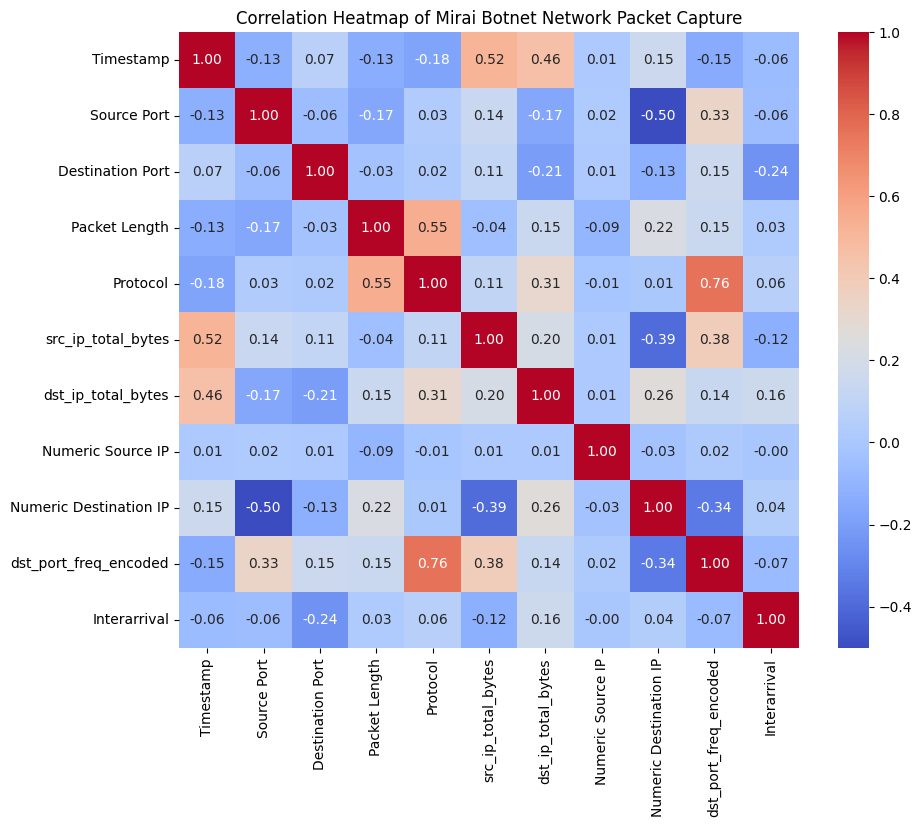

2024-05-15 18:54:28 [WARNING] Failed to execute code with a correction framework [retry number: 1]
2024-05-15 18:54:28 [ERROR] Failed with error: Traceback (most recent call last):
  File "/Users/polyxeni/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/pandasai/pipelines/smart_datalake_chat/code_execution.py", line 53, in execute
    result = pipeline_context.query_exec_tracker.execute_func(
  File "/Users/polyxeni/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/pandasai/helpers/query_exec_tracker.py", line 134, in execute_func
    step_data = self._generate_exec_step(tag, result)
  File "/Users/polyxeni/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/pandasai/helpers/query_exec_tracker.py", line 183, in _generate_exec_step
    self._response = self._format_response(result)
  File "/Users/polyxeni/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/pandasai/helpers/query_exec_tracker.py", line 202, in _format_response
    with open(result["value"], "

<string>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


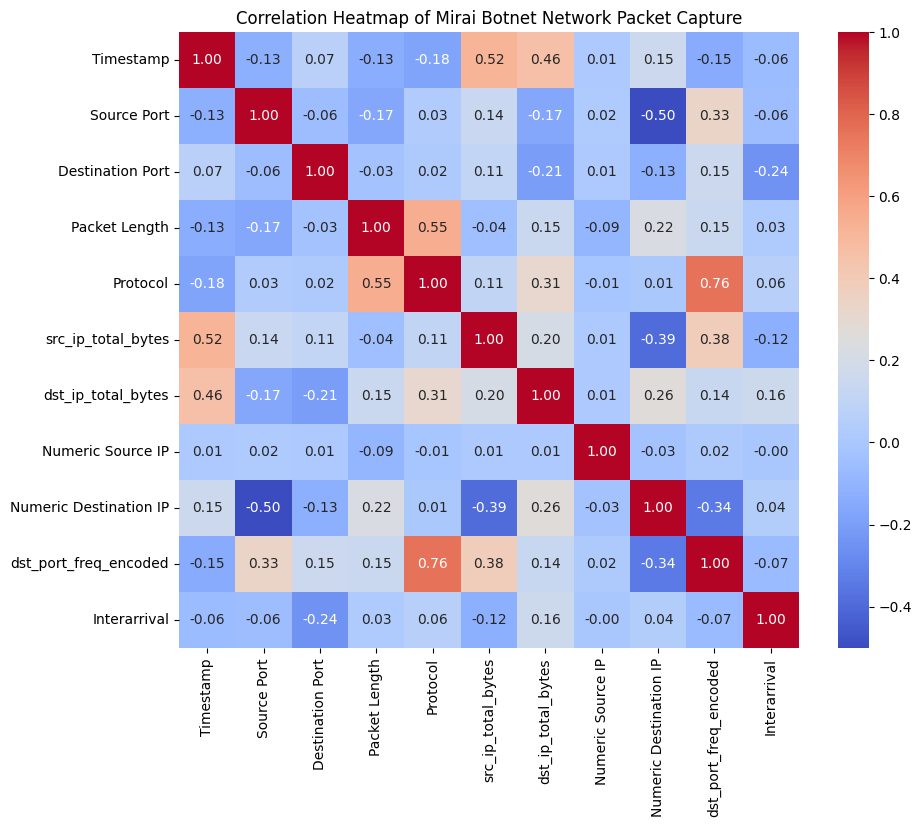

2024-05-15 18:54:31 [WARNING] Failed to execute code with a correction framework [retry number: 2]
2024-05-15 18:54:31 [ERROR] Failed with error: Traceback (most recent call last):
  File "/Users/polyxeni/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/pandasai/pipelines/smart_datalake_chat/code_execution.py", line 53, in execute
    result = pipeline_context.query_exec_tracker.execute_func(
  File "/Users/polyxeni/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/pandasai/helpers/query_exec_tracker.py", line 134, in execute_func
    step_data = self._generate_exec_step(tag, result)
  File "/Users/polyxeni/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/pandasai/helpers/query_exec_tracker.py", line 183, in _generate_exec_step
    self._response = self._format_response(result)
  File "/Users/polyxeni/sandbox/cyberdata-mlai/.venv/lib/python3.10/site-packages/pandasai/helpers/query_exec_tracker.py", line 202, in _format_response
    with open(result["value"], "

<string>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


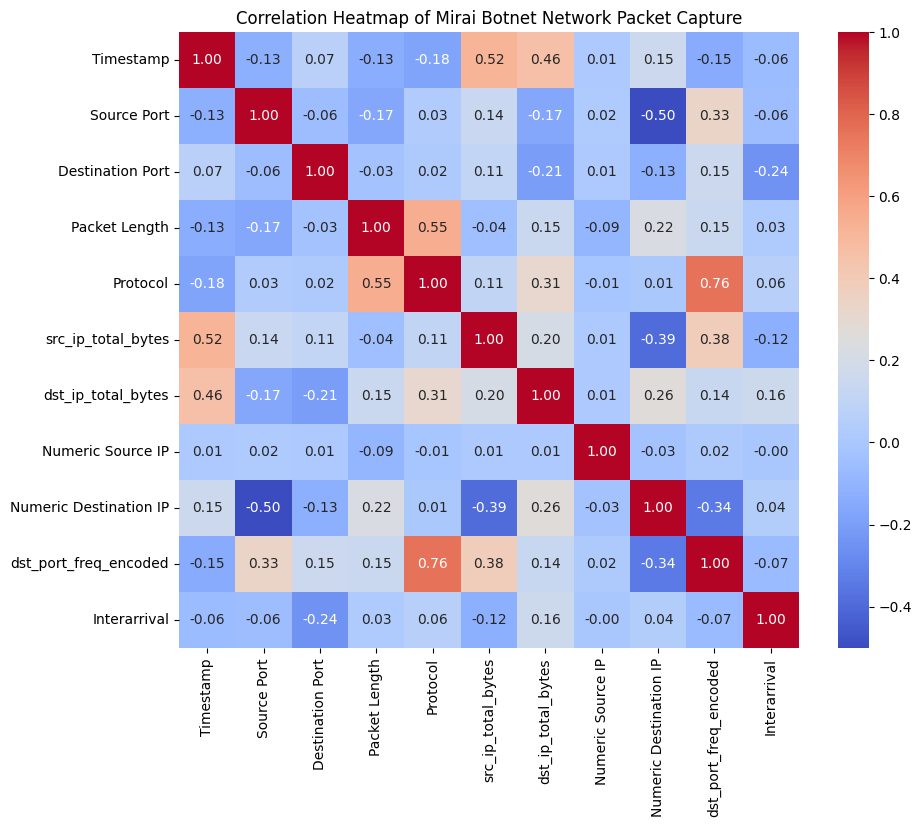

2024-05-15 18:54:34 [ERROR] Pipeline failed on step 4: expected str, bytes or os.PathLike object, not module


'Unfortunately, I was not able to answer your question, because of the following error:\n\nexpected str, bytes or os.PathLike object, not module\n'

In [18]:
malicious_smart.chat(
    "Plot the heatmap of the correlations of all variables."
)

In [19]:
print(malicious_smart.last_code_executed)

df = dfs[0]
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Mirai Botnet Network Packet Capture')
plt.show()
result = {'type': 'plot', 'value': plt}


2024-05-15 18:54:34 [INFO] Question: Plot a histogram for each of the variables.
2024-05-15 18:54:34 [INFO] Running PandasAI with openai LLM...
2024-05-15 18:54:34 [INFO] Prompt ID: 026629de-a19e-47f7-ac03-823ac4cf34c1
2024-05-15 18:54:34 [INFO] Executing Step 0: CacheLookup
2024-05-15 18:54:34 [INFO] Executing Step 1: PromptGeneration
2024-05-15 18:54:34 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x12
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
6897040485,20532.0,8280.0,Padding,26,6.0,52,26,7981437032,874070778,0.04079434096956324,5.0067901611328125e-06
3768484889,21074.0,80.0,Padding,26,6.0,26,26,9291380408,873999171,0.11450451035109352,
8500684032,2440.0,53.0,"DNS Qry ""b'xmpp.samsungsmartcam.com.Spee

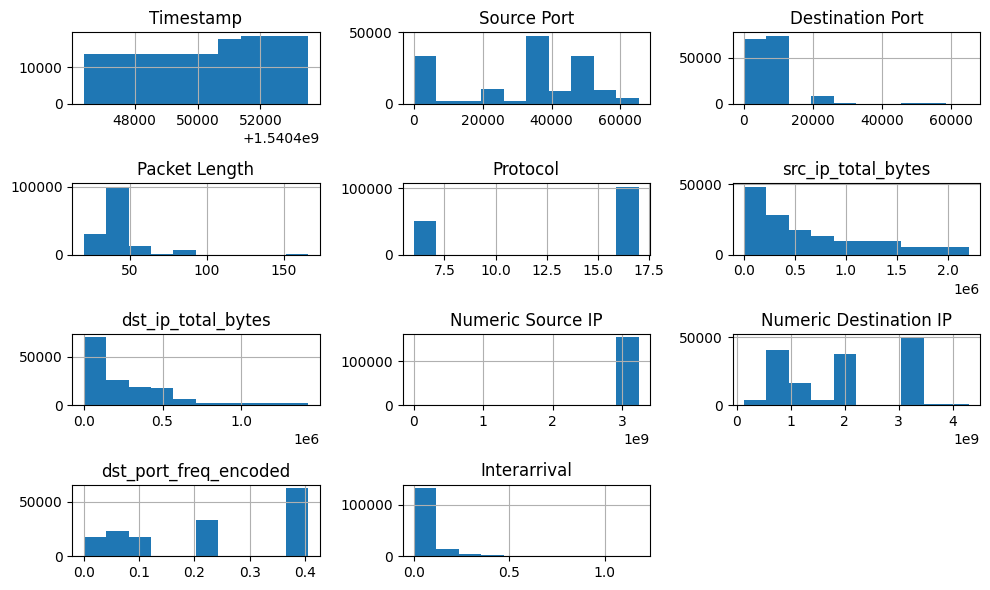

2024-05-15 18:54:38 [INFO] Executing Step 5: ResultValidation
2024-05-15 18:54:38 [INFO] Answer: {'type': 'plot', 'value': '/Users/polyxeni/sandbox/cyberdata-mlai/exports/charts/temp_chart.png'}
2024-05-15 18:54:38 [INFO] Executed in: 4.4675681591033936s
2024-05-15 18:54:38 [INFO] Executing Step 6: ResultParsing


'/Users/polyxeni/sandbox/cyberdata-mlai/exports/charts/temp_chart.png'

In [20]:
malicious_smart.chat("Plot a histogram for each of the variables.")

In [21]:
print(malicious_smart.last_code_executed)

for df in dfs:
    df.hist(figsize=(10, 6))
    plt.tight_layout()
    plt.show()
result = {'type': 'plot', 'value': '/Users/polyxeni/sandbox/cyberdata-mlai/exports/charts/temp_chart.png'}


# Agents

In [22]:
from pandasai import Agent

In [23]:
agent = Agent(malicious_smart, config={"llm": llm},memory_size=1000)

In [24]:
agent.chat('Is this dataframe indicating malicious or benign network behavior?')

2024-05-15 18:54:39 [INFO] Question: Is this dataframe indicating malicious or benign network behavior?
2024-05-15 18:54:39 [INFO] Running PandasAI with openai LLM...
2024-05-15 18:54:39 [INFO] Prompt ID: 50cb20b8-52ed-4792-982e-2ad2d1289ac1
2024-05-15 18:54:39 [INFO] Executing Step 0: CacheLookup
2024-05-15 18:54:39 [INFO] Executing Step 1: PromptGeneration
2024-05-15 18:54:39 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packet capture of the Mirai botnet network traffic.">
dfs[0]:154090x12
Timestamp,Source Port,Destination Port,Payload,Packet Length,Protocol,src_ip_total_bytes,dst_ip_total_bytes,Numeric Source IP,Numeric Destination IP,dst_port_freq_encoded,Interarrival
6897040485,20532.0,8280.0,Padding,26,6.0,52,26,7981437032,874070778,0.04079434096956324,5.0067901611328125e-06
3768484889,21074.0,80.0,Padding,26,6.0,26,26,9291380408,873999171,0.11450451035109352,
8500684032,2440.0,53.0,"DNS Qry ""b'xmpp.s

'Unfortunately, I was not able to answer your question, because of the following error:\n\nNo code found in the response\n'

In [25]:
agent.chat('The dataframe that you have been given is a packet capture of computer network traffic. It has numerical features that characterize the packets that have been observed in this network. A packet capture is malicious if it has too many requests to ports that are unusual. Usual ports are 23 for Telnet and 80 for HTTP. Is this packet capture malicious or benign?')

2024-05-15 18:54:42 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-05-15 18:54:42 [INFO] Check if the new message is related to the conversation: True
2024-05-15 18:54:42 [INFO] Question: The dataframe that you have been given is a packet capture of computer network traffic. It has numerical features that characterize the packets that have been observed in this network. A packet capture is malicious if it has too many requests to ports that are unusual. Usual ports are 23 for Telnet and 80 for HTTP. Is this packet capture malicious or benign?
2024-05-15 18:54:42 [INFO] Running PandasAI with openai LLM...
2024-05-15 18:54:42 [INFO] Prompt ID: 48033078-0f65-4ed8-8e1b-66a2572ddaab
2024-05-15 18:54:42 [INFO] Executing Step 0: CacheLookup
2024-05-15 18:54:42 [INFO] Executing Step 1: PromptGeneration
2024-05-15 18:54:42 [INFO] Using prompt: <dataframe name="Mirai botnet network packet capture." description="A dataframe that is derived from a packe

'The packet capture is malicious.'

In [26]:
agent.explain()

2024-05-15 18:54:47 [INFO] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-05-15 18:54:47 [INFO] Explanation:  I looked at the data to see how often certain ports were being accessed. I checked if the frequency of access to ports commonly used for Telnet and HTTP was higher than a certain threshold. If it was, I concluded that the packet capture was malicious; otherwise, I determined it to be benign.
                


'I looked at the data to see how often certain ports were being accessed. I checked if the frequency of access to ports commonly used for Telnet and HTTP was higher than a certain threshold. If it was, I concluded that the packet capture was malicious; otherwise, I determined it to be benign.'

# Clear cache

In [27]:
clear_cache()